# Preparación del Conjunto de Datos:
## 1º Cargaré el archivo csv donde están los datos y haré la preparación y selección de los datos para el modelo con los pasos que ejecuté en el sprint anterior.
* Selecciono los datos finanacieros y demográficos relevantes 

In [1]:
# Lo primero que hago es importar pandas para trabajar con los datos.
import pandas as pd 

# Creo un objeto que llamaré df donde con la función de pandas read.csv le indico la ruta del archivo.
df = pd.read_csv(r"C:\Users\javie\Downloads\bank_dataset.CSV")

# Indico las columnas que contienen los datos que quiero seleccionar.
df = df[['age','job','marital','education','default','balance','housing','loan','deposit']]

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11152 non-null  float64
 1   job        11162 non-null  object 
 2   marital    11157 non-null  object 
 3   education  11155 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11162 non-null  int64  
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   deposit    11162 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 785.0+ KB


## 2º Imputación de valores nulos

In [2]:
# Cuento los valores nulos en cada columna.
df.isnull().sum()

age          10
job           0
marital       5
education     7
default       0
balance       0
housing       0
loan          0
deposit       0
dtype: int64

* Hago la imputación de los valores nulos

In [3]:
# Sustituyo los nulos de la edad por su moda teniendo en cuenta los campos de job, marital y education ajustando los perfiles de coincidencia 
mediana_age = df.groupby(["job", "marital", "education"])["age"].transform(lambda x: x.median() if not x.isnull().all() else None)
df["age"] = df["age"].fillna(mediana_age.round())

# Sustituyo los nulos de marital con la moda de los registros teniendo en cuenta la edad y el trabajo para ajustar un poco más la coincidencia
moda_marital = df.groupby(["job", "age"])["marital"].transform(lambda x: x.mode()[0] if not x.isnull().all() else None)
df["marital"] = df["marital"].fillna(moda_marital)

# Sustituyo los nulos de education con la moda de los registros que tengan la misma edad y trabajo para ajustar la coincidencia
moda_education = df.groupby(["job", "age"])["education"].transform(lambda x: x.mode().iloc[0] if not x.isnull().all() else None)
df["education"] = df["education"].fillna(moda_education)

# Vuelvo a contar los valores nulos para comprobar de que han sido sustituidos
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
deposit      0
dtype: int64

## 3º Tratamiento de outliers.  
* Trato los outliers de age y balance como en el S5 y los guardo en un nuevo df_copy

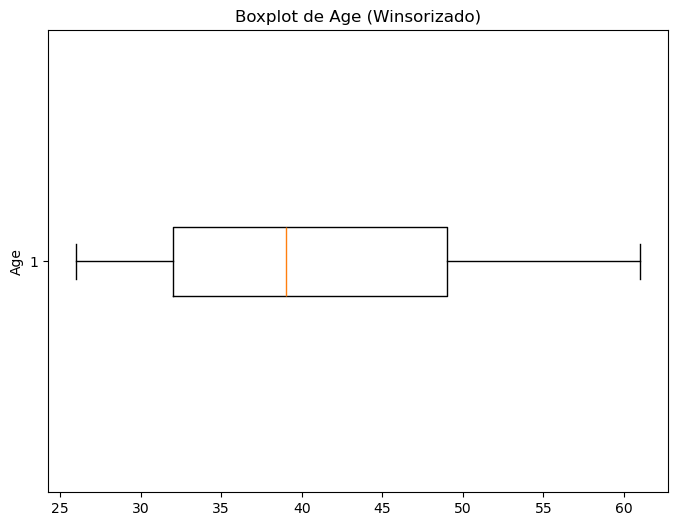

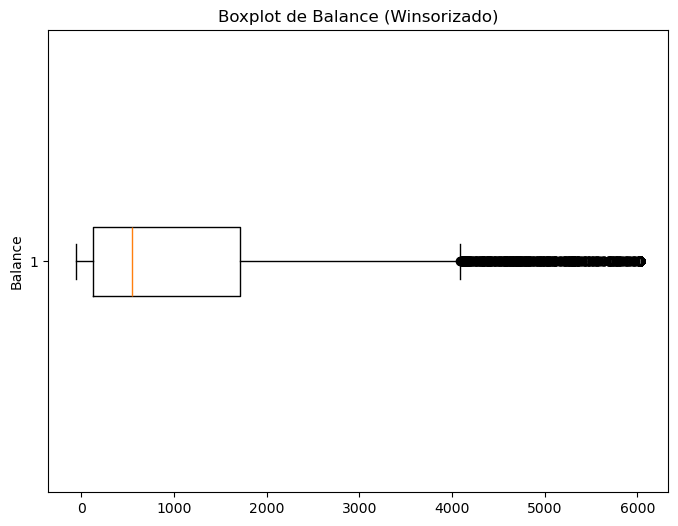

In [4]:
# Importo matplotlib para la gráfica y winsorize para tratar los outliers.
import matplotlib.pyplot as plt 
from scipy.stats.mstats import winsorize

# Creo una copia del DataFrame para evitar modificar el original
df_copy = df.copy()

# Reemplazo los valores extremos en las columnas 'age' y 'balance' por los valores de los percentiles 5 y 95.
df_copy['age'] = winsorize(df_copy['age'], limits=[0.05, 0.05])  # Limita los valores fuera de los percentiles 5-95
df_copy['balance'] = winsorize(df_copy['balance'], limits=[0.05, 0.05])  # Limita los valores fuera de los percentiles 5-95

# Creación del boxplot de la columna 'age' en el DataFrame winsorizado
plt.figure(figsize=(8, 6))
plt.boxplot(df_copy['age'], vert=False)
plt.title('Boxplot de Age (Winsorizado)')
plt.ylabel('Age')
plt.show()

# Creación del boxplot de la columna 'balance' en el DataFrame winsorizado
plt.figure(figsize=(8, 6))
plt.boxplot(df_copy['balance'], vert=False)
plt.title('Boxplot de Balance (Winsorizado)')
plt.ylabel('Balance')
plt.show()


# 4º División del conjunto de datos:
* La división la he realizado con un 80% de los datos para train (8,929 registros) y un 20% para test (2,233 registros). Considero esta proporción adecuada para un dataset de este tamaño, ya que permite entrenar el modelo con una cantidad significativa de datos mientras se reserva un conjunto suficiente para evaluar su rendimiento.
* Para mi modelo el cual será de aprendizaje supervisado estoy seleccionando deposit como etiqueta .

In [5]:
# Importo train_test_split de sklearn para dividir los datos en conjuntos de entrenamiento y prueba.
from sklearn.model_selection import train_test_split

# Creo el objeto 'X' para las características y el objeto 'Y' para la etiqueta o variable objetivo.
X = df_copy.loc[:, ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan']]
Y = df_copy.loc[:, ['deposit']]

# Realizo la separación de los datos en entrenamiento y prueba, utilizando el 20% para pruebas.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

# Imprimo la información sobre los conjuntos de entrenamiento y prueba.
print(f'Los datos de entrenamiento contienen {X_train.shape[0]} filas, {X_train.shape[1]} características y {Y_train.shape[1]} etiquetas.')
print(f'Los datos de prueba contienen {X_test.shape[0]} filas, {X_test.shape[1]} características y {Y_test.shape[1]} etiquetas.')


Los datos de entrenamiento contienen 8929 filas, 8 características y 1 etiquetas.
Los datos de prueba contienen 2233 filas, 8 características y 1 etiquetas.


# 5º Codificación de variables Categóricas:
* Busco las categorias en el df_copy


In [6]:
# Itero sobre las columnas del DataFrame que tienen tipo de dato 'object' (categóricas).
for column in df_copy.select_dtypes(include=['object']).columns:
    
    # Imprimo el nombre de la variable, su número total de categorías y la distribución de los valores.
    print(f"La variable {column.upper()} tiene un total de {df_copy[column].nunique()} categorías \
    \n{df_copy[column].value_counts()}\
    \n \n------------------------\n")


La variable JOB tiene un total de 12 categorías     
job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64    
 
------------------------

La variable MARITAL tiene un total de 3 categorías     
marital
married     6353
single      3518
divorced    1291
Name: count, dtype: int64    
 
------------------------

La variable EDUCATION tiene un total de 4 categorías     
education
secondary    5479
tertiary     3687
primary      1500
unknown       496
Name: count, dtype: int64    
 
------------------------

La variable DEFAULT tiene un total de 2 categorías     
default
no     10994
yes      168
Name: count, dtype: int64    
 
------------------------

La variable HOUSING tiene un total de 2 categorías     
housing
no     5881
yes    5281
Name: count, d

* Ejecuto Label Encoding para las características default, loan y housing ya que son características binarias ( yes/no)

In [7]:
# Defino las variables binarias
binary_variable = ['default', 'loan', 'housing']

# Convierto las características binarias en 0 y 1 usando map, tanto de datos de entrenamiento como de prueba
for variable in binary_variable:
    X_train[variable] = X_train[variable].map({'no': 0, 'yes': 1}).astype(int)
    X_test[variable] = X_test[variable].map({'no': 0, 'yes': 1}).astype(int)

# Convierto la etiqueta 'deposit' en 0 y 1, tanto de datos de entrenamiento como de prueba
Y_train['deposit'] = Y_train['deposit'].map({'no': 0, 'yes': 1}).astype(int)
Y_test['deposit'] = Y_test['deposit'].map({'no': 0, 'yes': 1}).astype(int)


* Ejecuto One Hot Encoding

In [8]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Copia los datos de entrenamiento y prueba
encoded_X_train = X_train.copy()
encoded_X_test = X_test.copy()

# Defino las variables categóricas para One-Hot Encoding
encoding_variable = ['job', 'marital', 'education']

# Inicializo el encoder
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Realizo el One-Hot Encoding de los datos de entrenamiento y prueba
for variable in encoding_variable:
    # Encoding de datos de entrenamiento
    encoded_train_results = encoder.fit_transform(X_train[[variable]])
    encoded_train_columns = pd.DataFrame(encoded_train_results, 
                                         columns=encoder.get_feature_names_out([variable]), 
                                         index=X_train.index)
    encoded_X_train = pd.concat([encoded_X_train, encoded_train_columns], axis="columns")

    # Encoding de datos de prueba
    encoded_test_results = encoder.transform(X_test[[variable]])
    encoded_test_columns = pd.DataFrame(encoded_test_results, 
                                        columns=encoder.get_feature_names_out([variable]), 
                                        index=X_test.index)
    encoded_X_test = pd.concat([encoded_X_test, encoded_test_columns], axis="columns")

# Elimino las columnas originales categóricas de X_train y X_test
encoded_X_train = encoded_X_train.drop(columns=encoding_variable)
encoded_X_test = encoded_X_test.drop(columns=encoding_variable)

# Imprimo los primeros registros de los datos procesados
print("\nEjemplo de datos de entrenamiento después de One-Hot Encoding:")
print(encoded_X_train.head())

print("\nEjemplo de datos de prueba después de One-Hot Encoding:")
print(encoded_X_test.head())



Ejemplo de datos de entrenamiento después de One-Hot Encoding:
        age  default  balance  housing  loan  job_blue-collar  \
2536   60.0        0      209        0     0              0.0   
8283   51.0        0     6027        1     0              0.0   
10439  58.0        0        0        0     0              0.0   
2809   61.0        0     6027        0     0              0.0   
5590   37.0        0      715        1     0              0.0   

       job_entrepreneur  job_housemaid  job_management  job_retired  ...  \
2536                0.0            0.0             0.0          1.0  ...   
8283                0.0            0.0             1.0          0.0  ...   
10439               0.0            0.0             0.0          1.0  ...   
2809                0.0            0.0             0.0          1.0  ...   
5590                0.0            0.0             1.0          0.0  ...   

       job_services  job_student  job_technician  job_unemployed  job_unknown  \
2536   

In [9]:
print(f'Los datos de entrenamiento contienen {encoded_X_train.shape[0]} filas, {encoded_X_train.shape[1]} características y {Y_train.shape[1]} etiqueta.')
print(f'Los datos de prueba contienen {encoded_X_test.shape[0]} filas, {encoded_X_test.shape[1]} características y {Y_test.shape[1]} etiqueta.')


Los datos de entrenamiento contienen 8929 filas, 21 características y 1 etiqueta.
Los datos de prueba contienen 2233 filas, 21 características y 1 etiqueta.


In [10]:
encoded_X_train.head()


,age,default,balance,housing,loan,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown
2536,60.0,0,209,0,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8283,51.0,0,6027,1,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10439,58.0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2809,61.0,0,6027,0,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5590,37.0,0,715,1,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


# Estandarización de las Variables Numéricas:
He decidido utilizar StandardScaler para la estandarización de las variables numéricas. Este método transforma los datos para que tengan una media de 0 y una desviación estándar de 1, lo que es especialmente útil cuando las características tienen diferentes escalas y magnitudes. La estandarización es una práctica común en el preprocesamiento de datos, ya que puede mejorar el rendimiento de muchos algoritmos de machine learning.


In [11]:
# Importo StandardScaler de sklearn.preprocessing para estandarizar las variables.
from sklearn.preprocessing import StandardScaler

# Identifico las columnas numéricas en los conjuntos codificados de entrenamiento y prueba.
numeric_columns = encoded_X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Creo el objeto escalador
scaler = StandardScaler()

# Aplico la estandarización en el conjunto de entrenamiento y luego en el de prueba
encoded_X_train[numeric_columns] = scaler.fit_transform(encoded_X_train[numeric_columns])
encoded_X_test[numeric_columns] = scaler.transform(encoded_X_test[numeric_columns])

# Visualizo los datos estandarizados en el conjunto de entrenamiento
encoded_X_train[numeric_columns].head()


,age,balance,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown
2536,1.823905,-0.634594,-0.455991,-0.179927,-0.161511,-0.546074,3.657653,-0.194043,-0.299055,-0.181908,-0.442306,-0.183218,-0.080154,0.866478,-0.675375,-0.980589,-0.701886,4.617629
8283,0.968317,2.854287,-0.455991,-0.179927,-0.161511,1.831253,-0.273399,-0.194043,-0.299055,-0.181908,-0.442306,-0.183218,-0.080154,0.866478,-0.675375,-0.980589,-0.701886,-0.216561
10439,1.633774,-0.759925,-0.455991,-0.179927,-0.161511,-0.546074,3.657653,-0.194043,-0.299055,-0.181908,-0.442306,-0.183218,-0.080154,-1.154097,-0.675375,1.019795,-0.701886,-0.216561
2809,1.918970,2.854287,-0.455991,-0.179927,-0.161511,-0.546074,3.657653,-0.194043,-0.299055,-0.181908,-0.442306,-0.183218,-0.080154,0.866478,-0.675375,-0.980589,-0.701886,-0.216561
5590,-0.362598,-0.331161,-0.455991,-0.179927,-0.161511,1.831253,-0.273399,-0.194043,-0.299055,-0.181908,-0.442306,-0.183218,-0.080154,-1.154097,1.480658,-0.980589,-0.701886,4.617629


Explicación del Resultado: En Age tomando como referencia los registros: 2536, 8283, 10439 teníamos :
Edad (original): 60, 51, 58 
Edad (estandarizado): 1.82, 0.96, 1.63 
Los valores numéricos se centran y normalizan, asegurando que cada variable tenga una influencia similar en el modelo, por lo que se puede ver que el registro 8283 es el que se acerca más a la media porque está más próximo a 0 mientras que el registro 2536 con 1.82 es el que más se aleja.
TENIENDO EN CUENTA QUE SOLO ESTAMOS TOMANDO ESTOS 3 REGISTROS PARA ESTA EXPLICACIÓN DE LOS RESULTADOS.

# Reducción de la Dimensionalidad utilizando PCA


In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Crear un objeto PCA sin especificar el número de componentes
pca = PCA()
# Ajustar el modelo a los datos estandarizados de entrenamiento
pca.fit(encoded_X_train[numeric_columns])


PCA()

In [14]:
# Obtener la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_
print("Varianza explicada por cada componente principal:", explained_variance)

# Calcular la varianza acumulada
cumulative_variance = explained_variance.cumsum()
print("Varianza explicada acumulada:", cumulative_variance)


Varianza explicada por cada componente principal: [0.13657308 0.12756881 0.07548458 0.07101434 0.06332396 0.06234342
 0.05910713 0.05784688 0.05752108 0.05736085 0.05245343 0.05012934
 0.04457403 0.03333207 0.02438013 0.01096828 0.00901704 0.00700156]
Varianza explicada acumulada: [0.13657308 0.26414189 0.33962646 0.4106408  0.47396476 0.53630818
 0.59541531 0.65326218 0.71078327 0.76814412 0.82059754 0.87072688
 0.91530092 0.94863298 0.97301312 0.9839814  0.99299844 1.        ]


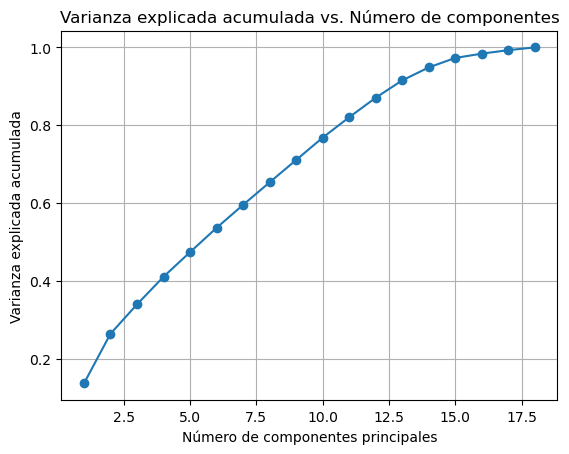

In [15]:
# Graficar la varianza explicada acumulada
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada acumulada vs. Número de componentes')
plt.grid()
plt.show()


* En el gráfico se puede ver que el codo cerca al 90% se alcanza en el CP 13 es por eso que ejecuto el codigo de abajo donde le indico el número de componentes necesarios para estar lo más cerca a ese 90%.
*  Posteriormente hago un print del número óptimo de componentes y otro de la varianza de cada uno de estos componentes.

In [17]:
# Seleccionar el número óptimo de componentes que capture el 90% de la varianza
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(encoded_X_train[numeric_columns])
X_test_pca = pca.transform(encoded_X_test[numeric_columns])

# Verificar el número de componentes seleccionados y la varianza explicada
print("Número de componentes seleccionados:", pca.n_components_)
print("Varianza explicada por los componentes seleccionados:", pca.explained_variance_ratio_)


Número de componentes seleccionados: 13
Varianza explicada por los componentes seleccionados: [0.13657308 0.12756881 0.07548458 0.07101434 0.06332396 0.06234342
 0.05910713 0.05784688 0.05752108 0.05736085 0.05245343 0.05012934
 0.04457403]
